### 1. Importing packages

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# checking gpu support
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tabulate import tabulate

In [7]:
# import splitfolders
import os
import numpy as np
import pandas as pd
import random

### 2. Loading dataset

In [9]:
# defining constants
BATCH_SIZE = 32
IMG_SIZE = 256
EPOCHS = 50

In [15]:
# project's main directory
prj_dir = 'E://projects//3-2//tomato//val'

In [17]:
# building tf input data pipeline
ds = tf.keras.utils.image_dataset_from_directory(
    f'{prj_dir}', 
    batch_size=BATCH_SIZE, 
    image_size=(IMG_SIZE, IMG_SIZE), 
    shuffle=True
)

Found 1000 files belonging to 10 classes.


In [19]:
# getting class names
class_names = ds.class_names
class_names

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

Batch 1 Imgs shape: (32, 256, 256, 3)
Batch 1 Lbls: [5 6 7 1 8 8 6 2 7 9 8 3 7 7 4 8 0 0 4 8 3 9 5 1 6 4 2 9 6 1 8 2]


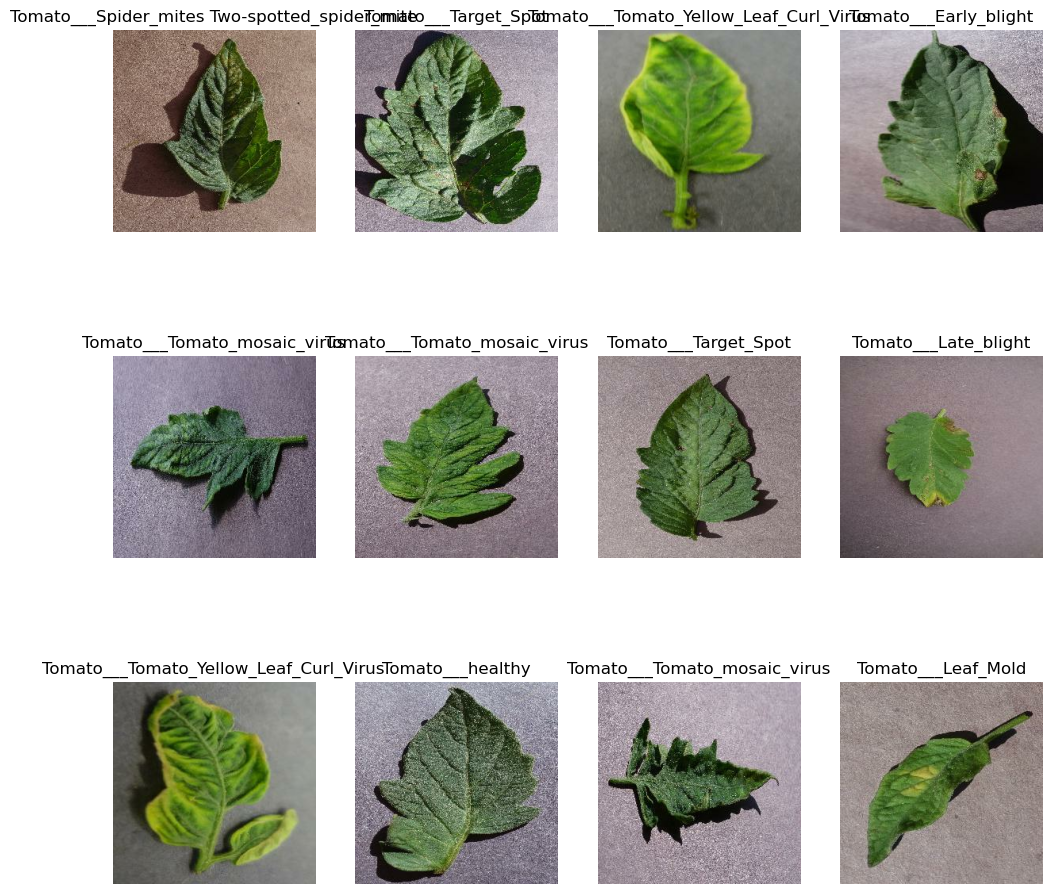

In [21]:
# displaying sample data
img = None

plt.figure(figsize=(12, 12))

for imgs, lbls in ds.take(1):
    print(f'Batch 1 Imgs shape: {imgs.shape}')
    print(f'Batch 1 Lbls: {lbls.numpy()}')

    img = imgs[0].numpy().astype('uint8') # taking sample image
    
    for i in range(12):
        plt.subplot(3, 4, i + 1)
        plt.imshow(imgs[i].numpy().astype('uint8'))
        plt.title(class_names[lbls[i]])
        plt.axis('off')

### 3. Data preprocessing

In [23]:
# creating training set, validation set and testing set
ds_size = len(ds)

ds = ds.shuffle(10000, seed=12)

# taking 10% for testing set and dividing remaining into 80/20 training/validation ratio
train_size = int(ds_size * 0.72) # 72%
train_set = ds.take(train_size)

val_size = int(ds_size * 0.18) # 18%
val_set = ds.skip(train_size).take(val_size)

test_set = ds.skip(train_size).skip(val_size)
test_size = len(test_set) # 10%

print(f'Dataset size   : {ds_size}')
print(f'Train set size : {train_size}')
print(f'Val set size   : {val_size}')
print(f'Test set size  : {test_size}')

Dataset size   : 32
Train set size : 23
Val set size   : 5
Test set size  : 4


In [25]:
# optimizing tf input data pipeline performance

# caching for epochs
# prefetching tf-determined data into CPU as GPU computes - AUTOTUNE
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [27]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

IMG_SIZE = 224  # Replace with your desired image size

resize_rescale = Sequential([
    layers.Resizing(IMG_SIZE, IMG_SIZE),  # during prediction
    layers.Rescaling(1.0 / 255)  # rescaling RGB values to between 0.0 and 1.0
])


In [29]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

data_aug = Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)
])


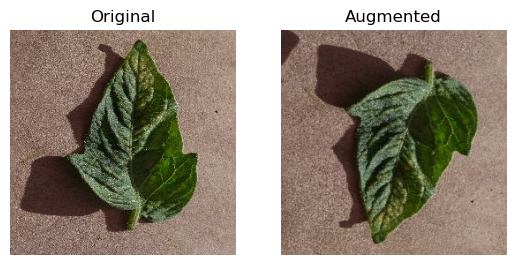

In [33]:
# testing data augmentation
imgs = [img, data_aug(img).numpy().astype('uint8')]
titles = ['Original', 'Augmented']
for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.imshow(imgs[i])
    plt.title(titles[i])
    plt.axis('off')

In [41]:
def random_rotate(image):
    # Randomly choose the number of 90-degree rotations
    k = tf.random.uniform([], 0, 4, dtype=tf.int32)  # Randomly choose between 0 and 3
    image = tf.image.rot90(image, k)
    return image

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = random_rotate(image)
    return image, label


In [43]:
# splitfolders.ratio(f'{prj_dir}/Data', 
#                    output=f'{prj_dir}/Subsets', 
#                    ratio=(.72, .18, .10)
#                    )

In [45]:
# train_imgs_gen = ImageDataGenerator(
#     rescale=1.0 / 255, 
#     horizontal_flip=True, 
#     vertical_flip=True, 
#     rotation_range=20
# )

# train_data_gen = train_imgs_gen.flow_from_directory(
#     f'{prj_dir}/Subsets/train', 
#     target_size=(IMG_SIZE, IMG_SIZE), 
#     batch_size=BATCH_SIZE, 
#     class_mode='sparse', # integer labels
#     # save_to_dir=f'{prj_dir}/Subsets/aug_train'
# )

# same for validation and testing sets

In [47]:
# for imgs, lbls in train_data_gen:
#     print(imgs.shape)
#     break

### 4. Model building

In [85]:
from tensorflow.keras import layers, models

# Assuming IMG_SIZE, BATCH_SIZE, and class_names are defined
IMG_SIZE = 256  # Example image size, adjust as needed
BATCH_SIZE = 32  # Example batch size, adjust as needed
n_classes = len(class_names)  # Number of classes

input_shape = (IMG_SIZE, IMG_SIZE, 3)  # 3 channels - RGB

# Building the model
model = models.Sequential([
    layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=input_shape), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'), 
    layers.MaxPooling2D((2, 2)), 
    layers.Flatten(),  # Ensure Flatten before Dense
    layers.Dense(units=64, activation='relu'), 
    layers.Dense(units=n_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Summary of the model
model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 184,202 (719.54 KB)

 Trainable params: 184,202 (719.54 KB)

 Non-trainable params: 0 (0.00 B)

In [87]:
model.summary() # all trainable parameters -> no transfer learning

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 60, 60, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_14 (MaxPooling2D)      │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 28, 28, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_15 (MaxPooling2D)      │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 12, 12, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_16 (MaxPooling2D)      │ (None, 6, 6, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 4, 4, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_17 (MaxPooling2D)      │ (None, 2, 2, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 64)                  │          16,448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 10)                  │             650 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 184,202 (719.54 KB)

 Trainable params: 184,202 (719.54 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
# compiling model with optimizer, loss and metrics
model.compile(
    optimizer='adam', 
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
    metrics=['accuracy']
)

### 5. Model fitting

In [91]:
train_dir = f'{prj_dir}' # training directory

In [93]:
train_ver = len(os.listdir(train_dir)) # latest saved training
print(f'Latest saved training ver: {train_ver}')

Latest saved training ver: 10


In [95]:
cps_dir = 'training-1/cp-{epoch:04d}.ckpt' # checkpoints directory

In [97]:
history = model.fit(
    train_set,                   # Training dataset
    epochs=EPOCHS,               # Number of epochs
    batch_size=BATCH_SIZE,       # Batch size
    validation_data=val_set,     # Validation dataset
    verbose=1                    # Verbosity mode
)


Epoch 1/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.1180 - loss: 6.6806 - val_accuracy: 0.1375 - val_loss: 2.2373
Epoch 2/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.2029 - loss: 2.1715 - val_accuracy: 0.2688 - val_loss: 2.0570
Epoch 3/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.2957 - loss: 1.9314 - val_accuracy: 0.2937 - val_loss: 2.0489
Epoch 4/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 66s 3s/step - accuracy: 0.4117 - loss: 1.6544 - val_accuracy: 0.4625 - val_loss: 1.5833
Epoch 5/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.4830 - loss: 1.4984 - val_accuracy: 0.5000 - val_loss: 1.3947
Epoch 6/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.5521 - loss: 1.2899 - val_accuracy: 0.4750 - val_loss: 1.3132
Epoch 7/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 64s 3s/step - accuracy: 0.6060 - loss: 1.0775 - val_accuracy: 0.6313 - val_loss: 1.1660
Epoch 8/50
23/23 ━━━━━━━━━━━━━━━━━━━━ 63s 3s/step - accuracy: 0.6258 - loss: 1.1130 - val_accuracy: 0.6812 - val_loss:

In [101]:
# getting metrics at every epoch
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

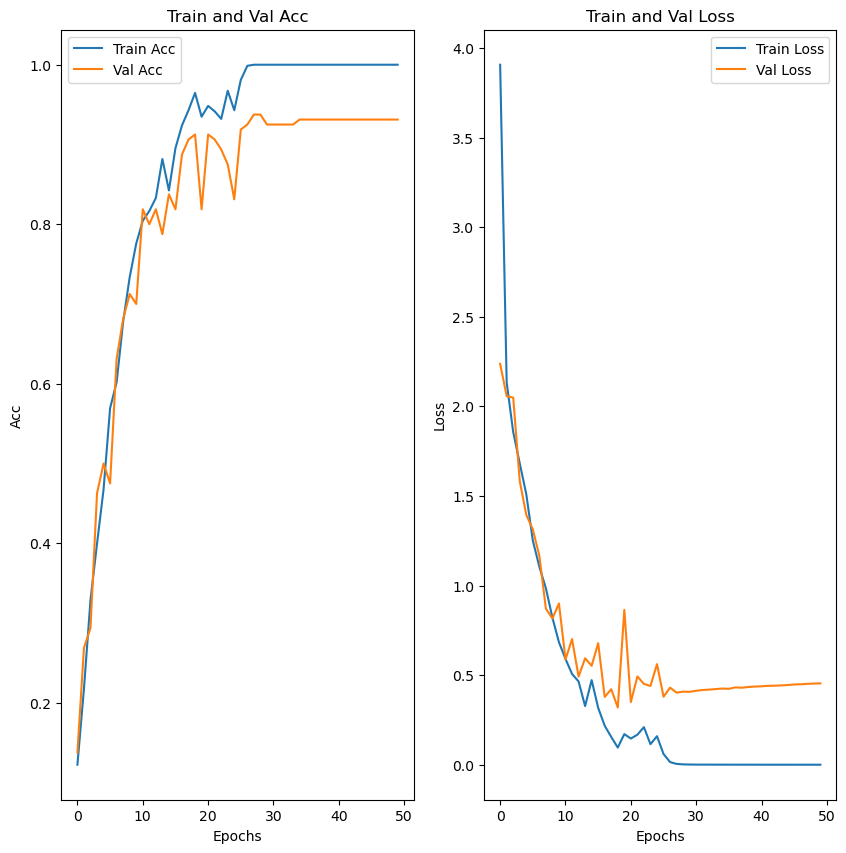

In [103]:
# plotting metrics at every epoch
train_metrics = [train_acc, train_loss]
val_metrics = [val_acc, val_loss]
metrics = ['Acc', 'Loss']

plt.figure(figsize=(10, 10))

for i in range(2):
    plt.subplot(1, 2, i + 1)
    plt.plot(range(EPOCHS), train_metrics[i], label=f'Train {metrics[i]}')
    plt.plot(range(EPOCHS), val_metrics[i], label=f'Val {metrics[i]}')
    plt.xlabel('Epochs')
    plt.ylabel(metrics[i])
    plt.title(f'Train and Val {metrics[i]}')
    plt.legend()

In [ ]:
# loading weights if saved training is available
# cps_dir = f'{train_dir}/training-1/'

# latest_cp = tf.train.latest_checkpoint(os.path.dirname(cps_dir))
# model.load_weights(latest_cp) # latest weights

# model.load_weights(f'{cps_dir}cp-0049.ckpt') # best weights

### 6. Model evaluation

In [107]:
# evaluating model using testing set
metrics = model.evaluate(test_set)
print(f'Loss : {round(100 * metrics[0], 2)}%')
print(f'Acc  : {round(100 * metrics[1], 2)}%')

4/4 ━━━━━━━━━━━━━━━━━━━━ 4s 717ms/step - accuracy: 0.9135 - loss: 0.6916
Loss : 62.6%
Acc  : 90.62%


In [109]:
# predicting labels of testing set and getting their confidences
lbls_true = []
lbls_pred = [] # predicted integer labels
pred_confs = [] # confidences

for i in range(test_size):
    for imgs, lbls in test_set.take(i + 1):
        lbls_true.extend(lbls.numpy().tolist())

        pred_imgs = model.predict(imgs)
        for pred_img in pred_imgs:
            lbls_pred.append(np.argmax(pred_img))
            pred_confs.append(np.max(pred_img))
        break

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 967ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


In [111]:
# changing integer labels to class names
lbls_true_names = list(map(lambda x: class_names[x], lbls_true))
lbls_pred_names = list(map(lambda x: class_names[x], lbls_pred))

In [113]:
# getting confusion matrix
cf_matrix = confusion_matrix(lbls_true_names, lbls_pred_names, labels=class_names)
cf_matrix_title = 'Confusion Matrix using Test Set'
print(cf_matrix_title)
print(cf_matrix)

Confusion Matrix using Test Set
[[ 8  0  0  0  0  0  0  2  0  0]
 [ 0 13  0  0  1  0  0  0  0  0]
 [ 0  0  9  1  1  2  0  0  0  0]
 [ 0  0  0 14  0  0  0  0  0  0]
 [ 1  3  0  0  8  0  0  0  0  0]
 [ 0  0  0  0  0  6  0  0  0  0]
 [ 0  0  0  0  0  1 11  0  0  0]
 [ 0  0  0  0  0  0  0 12  0  0]
 [ 0  0  0  1  0  0  0  0 18  0]
 [ 0  0  0  0  0  0  0  0  0 16]]


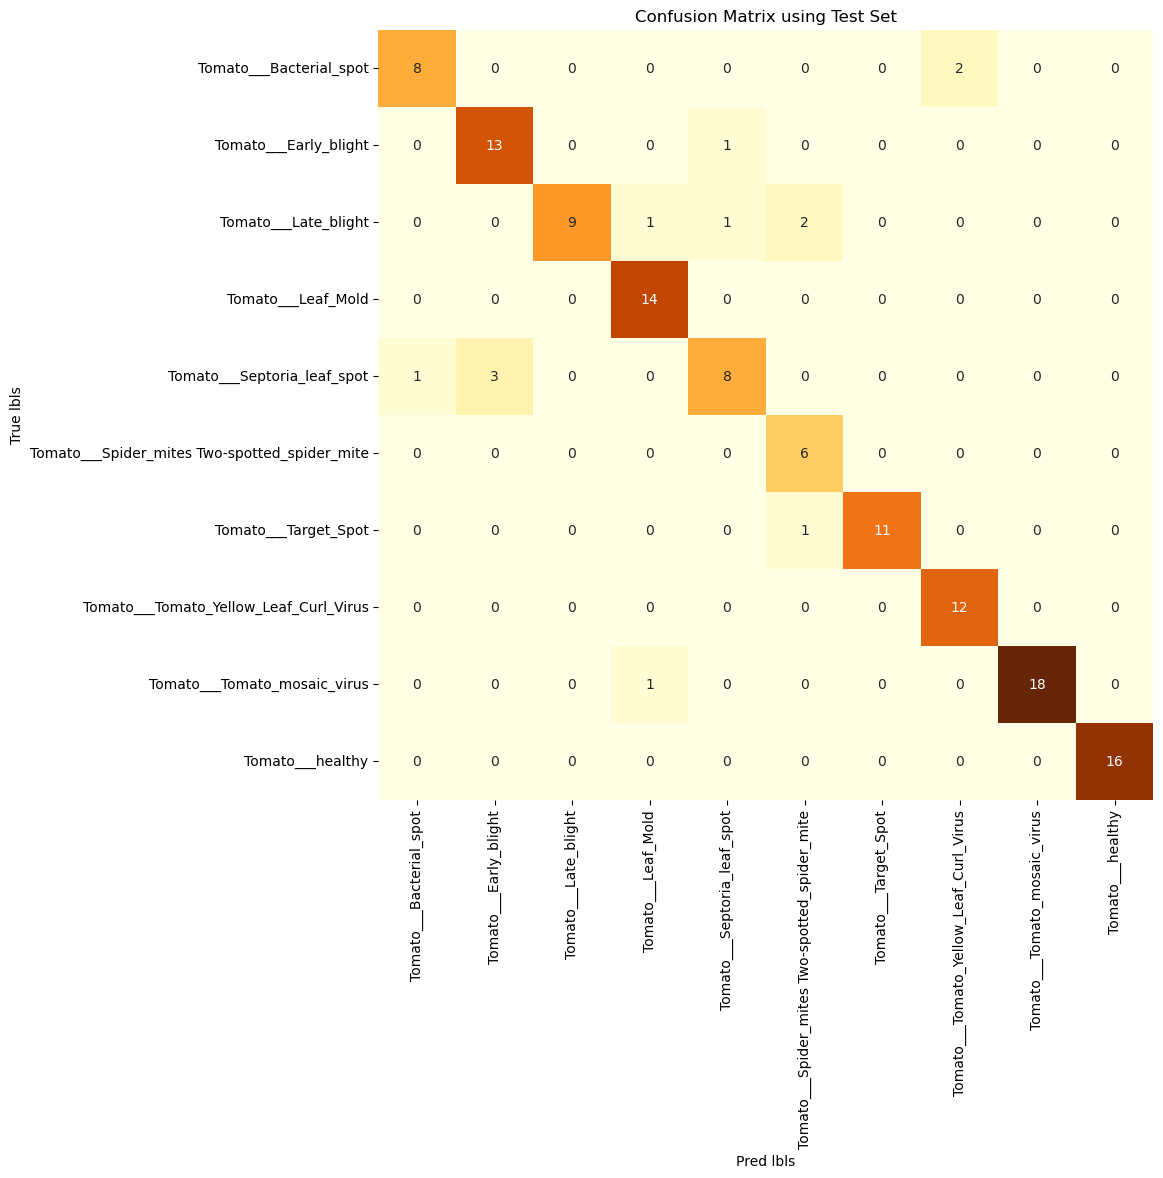

In [115]:
# plotting confusion matrix
plt.figure(figsize=(10, 10))
sns.heatmap(cf_matrix, annot=True, fmt='g', 
            xticklabels=class_names, yticklabels=class_names, 
            cbar=False, cmap='YlOrBr')
plt.xlabel('Pred lbls')
plt.ylabel('True lbls')
plt.title(cf_matrix_title)
plt.show()

In [117]:
# getting precisions
pred_sums = np.sum(cf_matrix, axis=0)
prec_matrix = cf_matrix / pred_sums
precs = prec_matrix.diagonal()

# getting recalls
true_sums = np.sum(cf_matrix, axis=1)
recall_matrix = cf_matrix / true_sums
recalls = recall_matrix.diagonal()

# getting f1 measures
f1s = (2 * precs * recalls) / (precs + recalls)

In [119]:
# displaying testing set counts
counts_tbl = []
for i in range(len(class_names)):
    counts_tbl.append([class_names[i], true_sums[i]])
counts_tbl.append(['Test set', sum(true_sums)])

print('Test set counts:')
print(tabulate(counts_tbl, tablefmt='grid'))

Test set counts:
+-----------------------------------------------+-----+
| Tomato___Bacterial_spot                       |  10 |
+-----------------------------------------------+-----+
| Tomato___Early_blight                         |  14 |
+-----------------------------------------------+-----+
| Tomato___Late_blight                          |  13 |
+-----------------------------------------------+-----+
| Tomato___Leaf_Mold                            |  14 |
+-----------------------------------------------+-----+
| Tomato___Septoria_leaf_spot                   |  12 |
+-----------------------------------------------+-----+
| Tomato___Spider_mites Two-spotted_spider_mite |   6 |
+-----------------------------------------------+-----+
| Tomato___Target_Spot                          |  12 |
+-----------------------------------------------+-----+
| Tomato___Tomato_Yellow_Leaf_Curl_Virus        |  12 |
+-----------------------------------------------+-----+
| Tomato___Tomato_mosaic_virus 

In [121]:
# displaying evaluations
evals_df = pd.DataFrame(data={'Precision': precs, 'Recall': recalls, 'F1': f1s}, 
                        index=class_names)
pd.options.display.float_format = '{:.2%}'.format
evals_df

,Precision,Recall,F1
Tomato___Bacterial_spot,88.89%,80.00%,84.21%
Tomato___Early_blight,81.25%,92.86%,86.67%
Tomato___Late_blight,100.00%,69.23%,81.82%
Tomato___Leaf_Mold,87.50%,100.00%,93.33%
Tomato___Septoria_leaf_spot,80.00%,66.67%,72.73%
Tomato___Spider_mites Two-spotted_spider_mite,66.67%,100.00%,80.00%
Tomato___Target_Spot,100.00%,91.67%,95.65%
Tomato___Tomato_Yellow_Leaf_Curl_Virus,85.71%,100.00%,92.31%
Tomato___Tomato_mosaic_virus,100.00%,94.74%,97.30%
Tomato___healthy,100.00%,100.00%,100.00%


In [123]:
macro_f1 = round(evals_df['F1'].mean() * 100, 2)
micro_f1 = round(np.sum(cf_matrix.diagonal()) / np.sum(cf_matrix) * 100, 2)
print(f'Macro F1: {macro_f1}%')
print(f'Micro F1: {micro_f1}%')

Macro F1: 88.4%
Micro F1: 89.84%


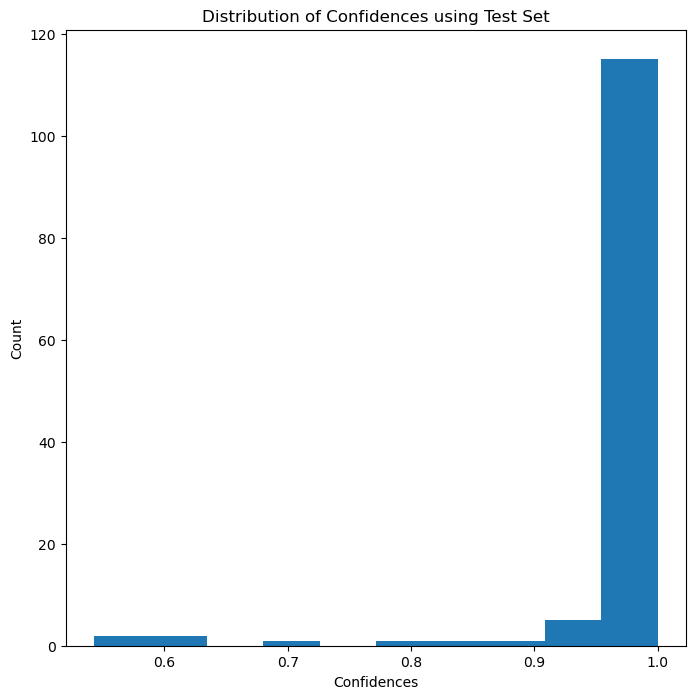

In [125]:
# plotting distribution of confidences
plt.figure(figsize=(8, 8))
plt.hist(pred_confs)
plt.xlabel('Confidences')
plt.ylabel('Count')
plt.title('Distribution of Confidences using Test Set')
plt.show()

True lbl : Tomato___Late_blight
Pred lbl : Tomato___Late_blight
Conf     : 100.0%


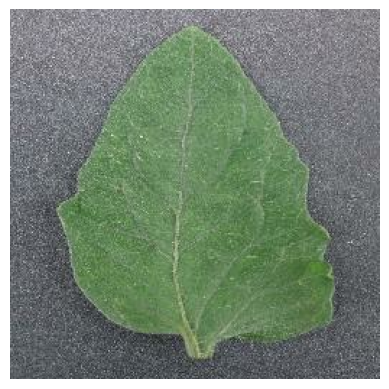

In [127]:
# displaying random image results
rand_batch = random.randint(1, test_size)
rand_img = random.randint(0, BATCH_SIZE - 1)

i = (rand_batch - 1) * BATCH_SIZE
lbl_true_name = lbls_true_names[i:i + BATCH_SIZE][rand_img]
lbl_pred_name = lbls_pred_names[i:i + BATCH_SIZE][rand_img]
pred_conf = pred_confs[i:i + BATCH_SIZE][rand_img]

print(f'True lbl : {lbl_true_name}')
print(f'Pred lbl : {lbl_pred_name}')
print(f'Conf     : {round(100 * pred_conf, 2)}%')

for imgs, lbls in test_set.take(rand_batch):
    plt.imshow(imgs[rand_img].numpy().astype('uint8'))
    plt.axis('off')
    break